In [ ]:
!pip install scipy
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Risk Parity Portfolio Implementation

This project aims to implement a risk parity portfolio using two different optimization methods. I will:
1. Construct a diversified portfolio of six stocks from different industries.
2. Calculate the optimal weight matrix using both methods.
3. Use one of the weight matrices to find the expected return and variance of the portfolio over a 5-month historical period.
4. Compare this variance to a portfolio weighted by market capitalization.

**Stocks Selection**

I chose six stocks from different industries to ensure diversification. The stocks are:
1. Technology: Microsoft (**MSFT**) - A key player in software, cloud computing, and artificial intelligence.
2. Financials: JPMorgan Chase (**JPM**) - A global financial services leader, providing diversified financial products and services.
3. Consumer Staples: Walmart (**WMT**) - The world's largest retailer.
4. Energy: Chevron (**CVX**) - Engages in comprehensive energy operations, from exploration to refining.
5. Industrials: Boeing (**BA**) - A major aerospace and defense company.
6. Healthcare: Johnson & Johnson (**JNJ**): Diversified across pharmaceuticals, medical devices, and consumer health products

In [ ]:
tickers = ['MSFT', 'JPM', 'WMT', 'CVX', 'BA', 'JNJ']
data = yf.download(tickers=tickers, period='6mo')
returns = data['Adj Close'].pct_change().dropna()

# Filter 5 months of data
current_date = pd.Timestamp.now()
five_months_ago = current_date - pd.DateOffset(months=5)
returns = returns[returns.index >= five_months_ago]

# Calculate the variance-covariance matrix
C = returns.cov()
print(tabulate(C, headers='keys', tablefmt='pretty'))


[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  6 of 6 completed


+--------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+
| Ticker |           BA           |          CVX           |          JNJ           |          JPM           |          MSFT          |          WMT           |
+--------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+
|   BA   | 0.00032949557405525436 | 1.612578566923704e-05  | 4.5062110870229084e-05 | 4.4011649261811756e-05 | 1.062211219283513e-05  | 4.827770303942653e-05  |
|  CVX   | 1.612578566923704e-05  | 0.00011044109678898118 | 1.7685880919771483e-05 | 5.2436688056451276e-05 | -2.057336695598756e-06 | 8.754951285981717e-06  |
|  JNJ   | 4.5062110870229084e-05 | 1.7685880919771483e-05 | 9.203421769120207e-05  | 3.8282440628812365e-05 | 5.019448868949616e-06  | 1.6846506657740188e-05 |
|  JPM   | 4.4011649261811756e-05 

**Method 1: Risk Parity using Marginal Contribution to Risk (MCR)**

The first method uses the marginal contribution to risk (MCR) to allocate weights such that each asset contributes equally to the overall portfolio risk.


In [ ]:
# Method 1 Implementation
def obj_function_1(w, C):
    P = C @ w
    MCR = P / np.sqrt(w.T @ C @ w)
    f = sum((w[i] * MCR[i] - w[j] * MCR[j]) ** 2 for i in range(len(w)) for j in range(len(w)))
    return f

def objective_1(w):
    return obj_function_1(w, C)

# Constraints and bounds
constraints = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Equality constraint: sum(w) = 1
    {'type': 'ineq', 'fun': lambda w: w}             # Inequality constraint: w >= 0
)
C = np.array(C)
bounds = [(0, 1) for _ in range(C.shape[1])]

# Pertubating Initial Guess
np.random.seed(42)
w0 = np.ones(len(tickers)) / len(tickers) + np.random.normal(0, 0.01, len(tickers))
w0 /= np.sum(w0)

result_1 = minimize(objective_1, w0, method='SLSQP', constraints=constraints, bounds=bounds, options={'disp': True, 'maxiter': 1000, 'ftol': 1e-15})
optimal_weights_1 = result_1.x

print("Optimal weights:", optimal_weights_1)
print("Objective function value at optimal weights:", result_1.fun)
print("Success:", result_1.success)
print("Message:", result_1.message)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.7869466834330293e-17
            Iterations: 46
            Function evaluations: 322
            Gradient evaluations: 46
Optimal weights: [0.1022337  0.18635403 0.18551143 0.13915639 0.20361304 0.18313142]
Objective function value at optimal weights: 1.7869466834330293e-17
Success: True
Message: Optimization terminated successfully


**Method 2: Risk Parity using Variance Minimization**

The second method minimizes the overall portfolio variance subject to a constraint on the log of the weights.


In [ ]:
#METHOD-2 IMPLEMNTATION

def obj_function_2(w, C):
    return np.sqrt(w.T @ C @ w)

def objective_2(w):
    return obj_function_2(w, C)

w0 = np.ones(len(tickers)) / len(tickers) + np.random.normal(0, 0.01, len(tickers))
w0 /= np.sum(w0)
C = np.array(C)

# Constraints
constraints = (
    {'type': 'ineq', 'fun': lambda w: np.sum(np.log(w)) + 2 },
    {'type': 'ineq', 'fun': lambda w: w}
)

# Bounds
bounds = [(0, 1) for _ in range(C.shape[1])]

# Optimize
result_2 = minimize(objective_2, w0, method='SLSQP', constraints=constraints, bounds=bounds, options={'disp': True, 'maxiter': 1000, 'ftol': 1e-15})
# Optimal weights
optimal_weights_2 = result_2.x
optimal_weights_2 /= np.sum(optimal_weights_2)

print("Optimal weights:", optimal_weights_2)
print("Objective function value at optimal weights:", result_2.fun)
print("Success:", result_2.success)
print("Message:", result_2.message)

y = np.array(optimal_weights_2)
#Normalise
w = y/np.sum(y)
print(w)   #Final weight matrix

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02725836730069789
            Iterations: 41
            Function evaluations: 288
            Gradient evaluations: 41
Optimal weights: [0.10223369 0.18635399 0.18551157 0.13915637 0.203613   0.18313138]
Objective function value at optimal weights: 0.02725836730069789
Success: True
Message: Optimization terminated successfully
[0.10223369 0.18635399 0.18551157 0.13915637 0.203613   0.18313138]


**Expected return and variance using Risk Parity Portfolio Weights**


In [ ]:
expected_return_1 = np.sum(returns.mean() * optimal_weights_1)
portfolio_variance_1 = np.dot(optimal_weights_1.T, np.dot(C, optimal_weights_1))
print("Expected Portfolio Return for Method-1:", expected_return_1)
print("Expected Portfolio Variance for Method-1:", portfolio_variance_1)

Expected Portfolio Return for Method-1: 0.0007530367569639873
Expected Portfolio Variance for Method-1: 3.8164042855105406e-05


In [ ]:
expected_return_2 = np.sum(returns.mean() * optimal_weights_2)
portfolio_variance_2 = np.dot(optimal_weights_2.T, np.dot(C, optimal_weights_2))
print("Expected Portfolio Return for Method-2:", expected_return_2)
print("Expected Portfolio Variance for Method-2:", portfolio_variance_2)

Expected Portfolio Return for Method-2: 0.000753036510863425
Expected Portfolio Variance for Method-2: 3.816404216972506e-05


**Expected return and variance using Weights based on Market Capitalizations**

In [ ]:
tickers = ['MSFT', 'JPM', 'WMT', 'CVX', 'BA', 'JNJ']
market_caps = []

for ticker in tickers:
    stock = yf.Ticker(ticker)
    market_cap = stock.info.get('marketCap', 'N/A')
    market_caps.append(market_cap)

market_caps = np.array(market_caps, dtype=float)
print("Market Capitalizations: ", market_caps)

w_mcap = market_caps / np.sum(market_caps)
print("Weights based on Market Capitalizations: ", w_mcap)

print("\n")

expected_return_mc = np.sum(returns.mean() * w_mcap) * 252
portfolio_variance_mc = np.dot(w_mcap.T, np.dot(C * 252, w_mcap))
print("Expected Portfolio Return for Method-2:", expected_return_mc)
print("Expected Portfolio Variance for Method-2:", expected_return_mc)

Market Capitalizations:  [3.45557801e+12 5.91549628e+11 5.63289063e+11 2.80044143e+11
 1.13675977e+11 3.49714678e+11]
Weights based on Market Capitalizations:  [0.64543778 0.11049048 0.10521193 0.05230704 0.02123256 0.06532021]


Expected Portfolio Return for Method-2: -0.10024208702731344
Expected Portfolio Variance for Method-2: -0.10024208702731344


**Result Collection/ Comparision**

In [ ]:
from tabulate import tabulate

results = pd.DataFrame({
    'Portfolio': ['Risk Parity (Method 1)', 'Risk Parity (Method 2)', 'Market Cap Weighted'],
    'Expected Return': [expected_return_1, expected_return_2, expected_return_mc],
    'Variance': [portfolio_variance_1, portfolio_variance_2, portfolio_variance_mc]
})

print(tabulate(results, headers='keys', tablefmt='pretty'))


+---+------------------------+-----------------------+------------------------+
|   |       Portfolio        |    Expected Return    |        Variance        |
+---+------------------------+-----------------------+------------------------+
| 0 | Risk Parity (Method 1) | 0.0007530367569639873 | 3.8164042855105406e-05 |
| 1 | Risk Parity (Method 2) | 0.000753036510863425  | 3.816404216972506e-05  |
| 2 |  Market Cap Weighted   | -0.10024208702731344  |  0.039898066670130725  |
+---+------------------------+-----------------------+------------------------+


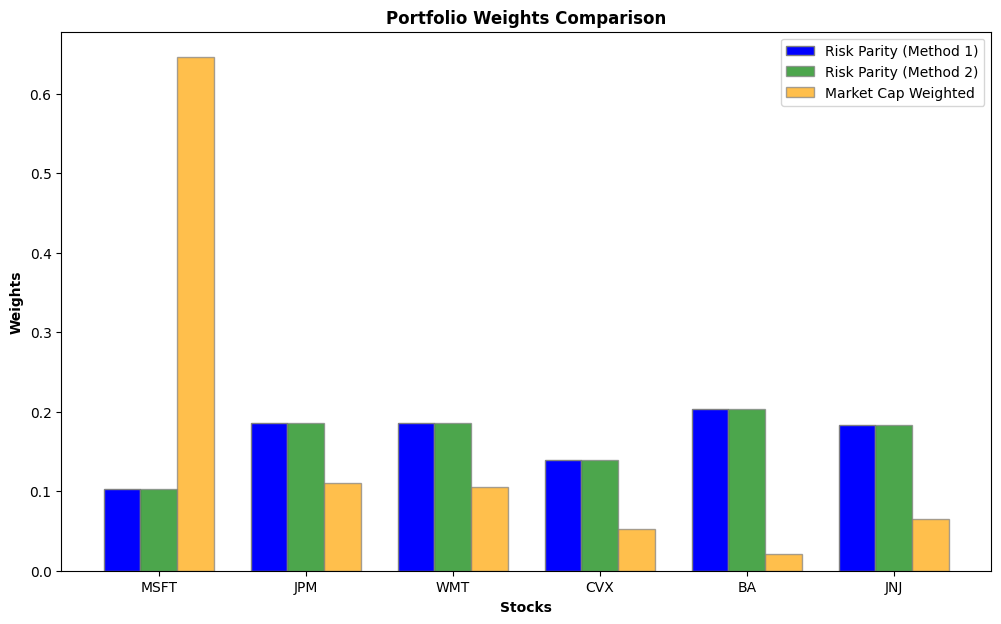

In [ ]:
plt.figure(figsize=(12, 7))
bar_width = 0.25

r1 = np.arange(len(tickers))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.bar(r1, optimal_weights_1, color='blue', width=bar_width, edgecolor='grey', label='Risk Parity (Method 1)')
plt.bar(r2, optimal_weights_2, color='green', width=bar_width, edgecolor='grey', alpha=0.7, label='Risk Parity (Method 2)')
plt.bar(r3, w_mcap, color='orange', width=bar_width, edgecolor='grey', alpha=0.7, label='Market Cap Weighted')

plt.xlabel('Stocks', fontweight='bold')
plt.ylabel('Weights', fontweight='bold')
plt.title('Portfolio Weights Comparison', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(tickers))], tickers)
plt.legend()

plt.show()

In [ ]:
portfolio_2_returns = (returns * optimal_weights_2).sum(axis=1)
market_cap_weighted_returns = (returns * w_mcap).sum(axis=1)

portfolio_2_returns = (returns * optimal_weights_2).sum(axis=1)
market_cap_weighted_returns = (returns * w_mcap).sum(axis=1)

cumulative_returns_2 = (1 + portfolio_2_returns).cumprod() - 1
cumulative_market_cap_returns = (1 + market_cap_weighted_returns).cumprod() - 1


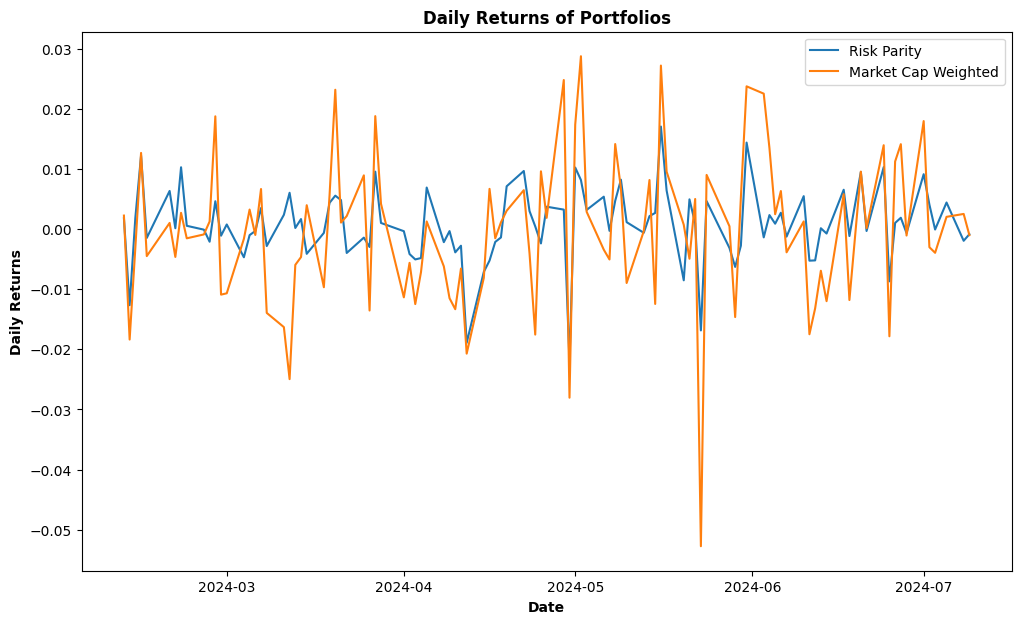

In [ ]:
# Plotting the non-cumulative (daily) returns
plt.figure(figsize=(12, 7))
plt.plot(portfolio_2_returns, label='Risk Parity')
plt.plot(market_cap_weighted_returns, label='Market Cap Weighted')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Daily Returns', fontweight='bold')
plt.title('Daily Returns of Portfolios', fontweight='bold')
plt.legend()
plt.show()

The graph provides insights into the behavior of two different portfolio strategies. The Risk Parity portfolio demonstrates lower volatility and more stable returns, and, the Market Cap Weighted portfolio, with its higher volatility, might be better suited for those seeking potentially higher returns while being willing to tolerate greater risk.


1.   **Volatility Comparison:**

*   The Market Cap Weighted portfolio exhibits higher volatility, with more spikes and troughs compared to the Risk Parity portfolio.
*   This increased volatility in the Market Cap Weighted portfolio could be due to the larger influence of certain stocks with higher market capitalization, leading to larger fluctuations in returns.

2.   **Trend Analysis:**

*   Both portfolios show a general pattern of daily returns fluctuating around zero.
*   The Risk Parity portfolio appears to have smoother fluctuations, suggesting a more balanced allocation that reduces the impact of individual stock movements on the overall portfolio returns.

3.   **Performance during Specific Periods:**

*   Around March and June 2024, there are noticeable spikes and drops in the Market Cap Weighted portfolio. These periods could correspond to specific market events affecting larger companies more significantly.
*   The Risk Parity portfolio, while also affected by these events, shows less extreme movements, indicating its diversified approach helps in mitigating the impact of market volatility.

4.   **Correlation between Portfolios:**
*   Despite the differences in volatility, both portfolios tend to follow a similar overall trend, reflecting the underlying market conditions affecting all stocks to some extent.
*   However, the magnitude of changes differs, with the Market Cap Weighted portfolio showing more extreme values.
5.   **Risk Management:**

*   The smoother line of the Risk Parity portfolio suggests it might be better suited for risk-averse investors who prefer stable returns with lower volatility.
*   The Market Cap Weighted portfolio might appeal to those seeking higher returns, accepting the accompanying higher risk and volatility.
6.  **Impact of Market Cap Weighting:**

*   The higher peaks and deeper troughs in the Market Cap Weighted portfolio highlight the influence of large-cap stocks. Significant movements in these stocks disproportionately impact the portfolio.
*   In contrast, the Risk Parity portfolio aims to equalize the risk contribution of each stock, resulting in a more stable return profile.

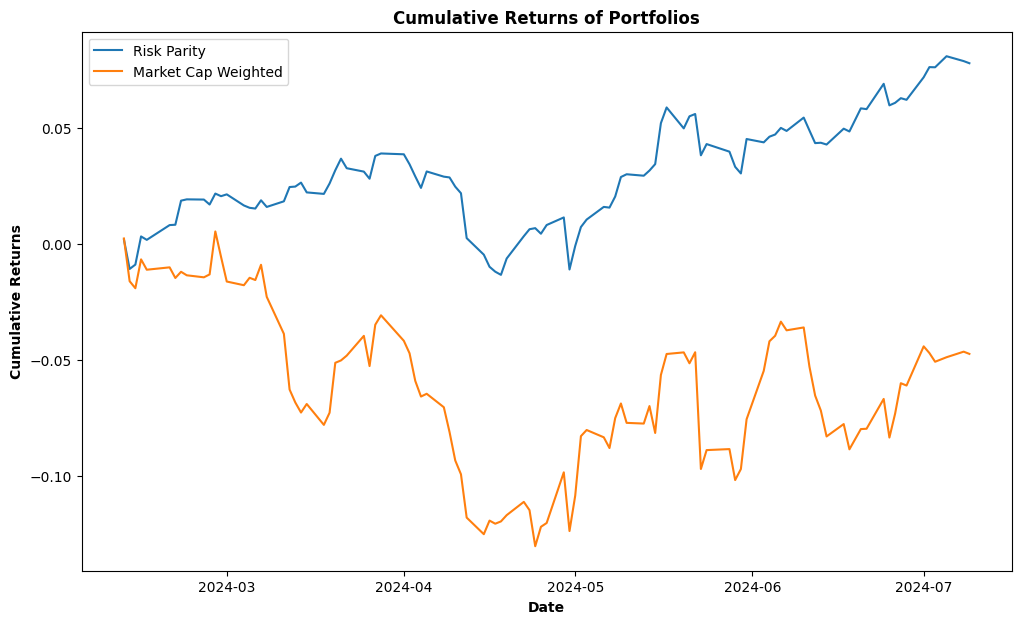

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(cumulative_returns_2, label='Risk Parity')
plt.plot(cumulative_market_cap_returns, label='Market Cap Weighted')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Cumulative Returns', fontweight='bold')
plt.title('Cumulative Returns of Portfolios', fontweight='bold')
plt.legend()
plt.show()

The graph illustrates the cumulative returns of two portfolios over time. The Risk Parity portfolio consistently shows positive growth, indicating its stable and balanced nature, while the Market Cap Weighted portfolio suffers significant drawdowns, reflecting higher volatility and risk, ultimately leading to negative cumulative returns. This suggests that the Risk Parity approach provides better risk-adjusted returns compared to the Market Cap Weighted strategy in this period.

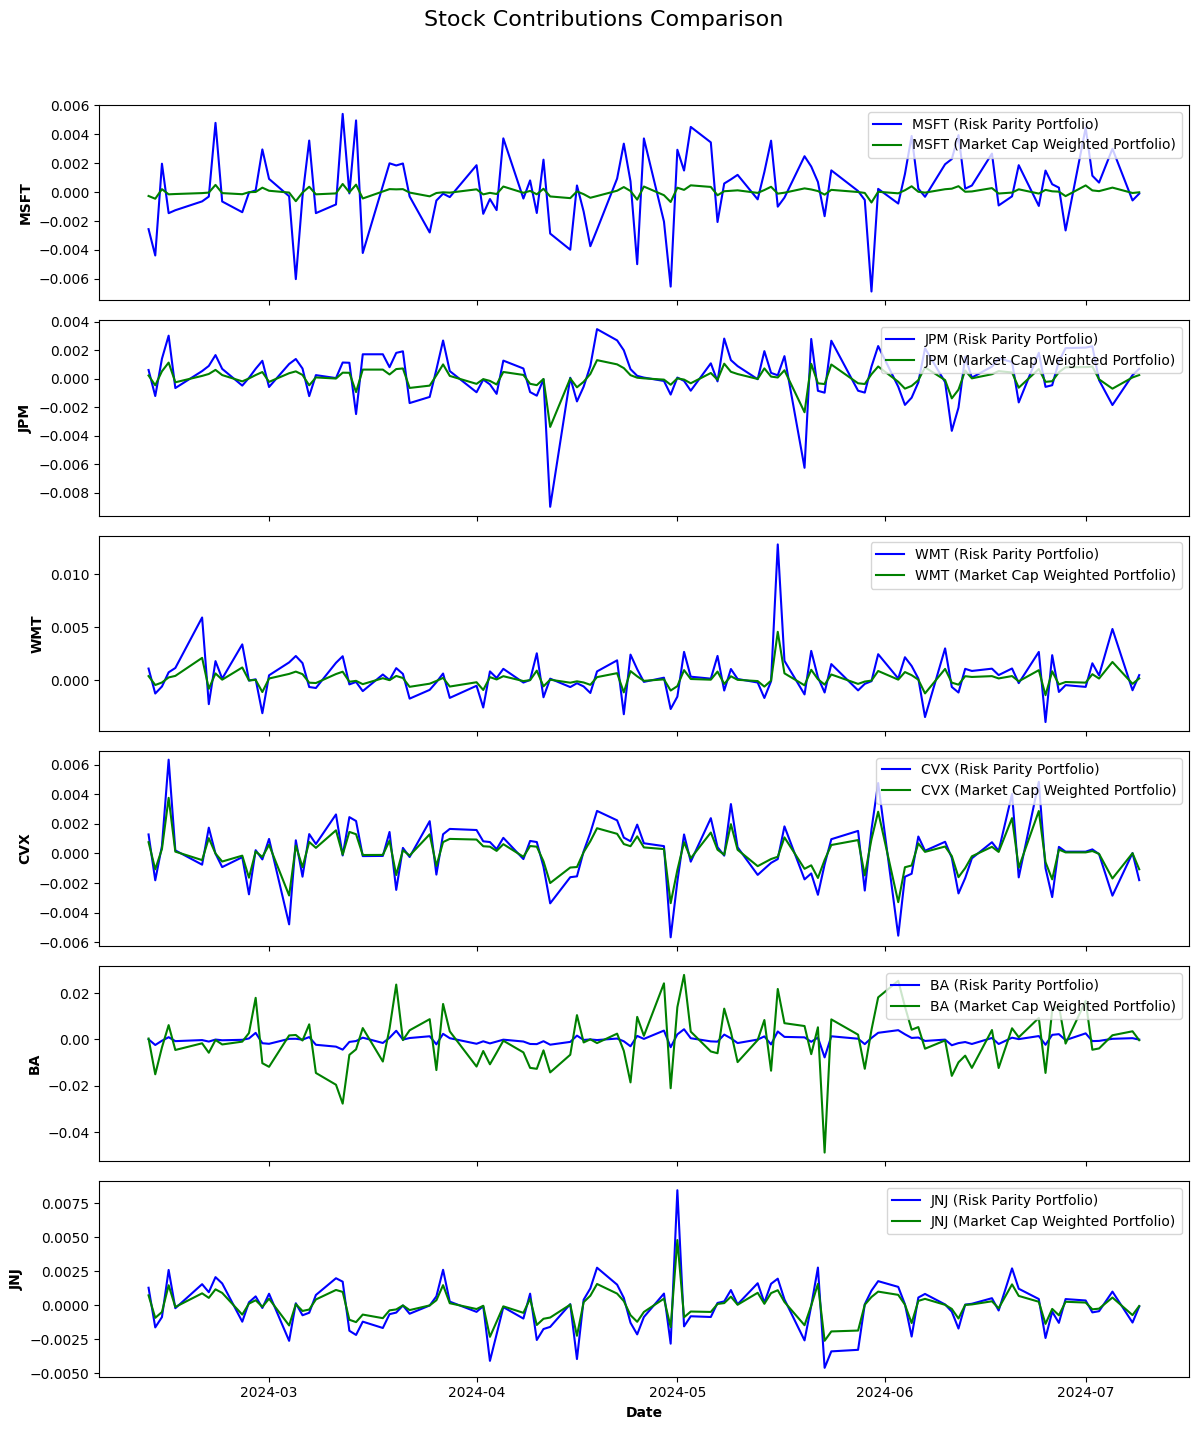

In [ ]:
contributions_1 = returns * optimal_weights_1
contributions_2 = returns * w_mcap

fig, axs = plt.subplots(len(tickers), 1, figsize=(12, 15), sharex=True)
fig.suptitle('Stock Contributions Comparison', fontsize=16)

for i, ticker in enumerate(tickers):
    axs[i].plot(returns.index, contributions_1[ticker], label=f'{ticker} (Risk Parity Portfolio)', color='blue')
    axs[i].plot(returns.index, contributions_2[ticker], label=f'{ticker} (Market Cap Weighted Portfolio)', color='green')
    axs[i].set_ylabel(ticker, fontweight='bold')
    axs[i].legend(loc='upper right')

plt.xlabel('Date', fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()